In [97]:
from pathlib import Path
cands = [p for p in Path('.').glob('*.csv') if 'supply' in p.name.lower()]
assert len(cands)>0, "Bu klasörde 'supply' içeren bir CSV bulamadım."
DATA_PATH = str(sorted(cands, key=lambda p: p.stat().st_mtime)[-1])
DATA_PATH


'supply_chain_deliveries.csv'

In [98]:
!pip install --quiet pandas numpy matplotlib scikit-learn scipy prophet

DATA_PATH = "supply_chain_deliveries.csv"  


In [99]:
import pandas as pd, numpy as np

df = pd.read_csv(DATA_PATH, engine="python")

df["WorkDate"] = pd.to_datetime(df["WorkDate"], errors="coerce")

for c in ["OrderCount", "NumberOfPieces", "TotalRevenue"]:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(",", ""), errors="coerce")

print("Boyut:", df.shape)
print("Tarih aralığı:", df["WorkDate"].min().date(), "→", df["WorkDate"].max().date())
df.head(5)


Boyut: (126255, 7)
Tarih aralığı: 2020-01-02 → 2025-06-30


,WorkDate,Customer,Location,BusinessType,OrderCount,NumberOfPieces,TotalRevenue
0,2020-01-02,Amazon,Chicago,Final Mile,38,190,2084.09
1,2020-01-02,Home Depot,Sacramento,Final Mile,34,136,6153.01
2,2020-01-02,Home Depot,Chicago,Final Mile,43,215,15691.72
3,2020-01-02,Home Depot,Detroit,Final Mile,41,164,6490.39
4,2020-01-02,Home Depot,Atlanta,Final Mile,44,220,10069.65


In [100]:
import pandas as pd
daily = (df
    .groupby(df["WorkDate"].dt.date)
    .agg(Orders=("OrderCount","sum"),
         Pieces=("NumberOfPieces","sum"),
         Revenue=("TotalRevenue","sum"))
    .reset_index()
    .rename(columns={"WorkDate":"ds"}))

daily["ds"] = pd.to_datetime(daily["ds"])
daily = daily.sort_values("ds").reset_index(drop=True)

print(daily.tail(3))
daily[["Orders","Pieces","Revenue"]].describe().T


             ds  Orders  Pieces    Revenue
1984 2025-06-28     499    2514   47659.12
1985 2025-06-29     485    2364   42286.89
1986 2025-06-30    2291   11823  244254.72


,count,mean,std,min,25%,50%,75%,max
Orders,1987.0,1746.586311,1187.767454,236.00,818.500,1490.00,2326.500,5750.00
Pieces,1987.0,8733.508304,5943.544037,1156.00,4100.500,7467.00,11606.500,28593.00
Revenue,1987.0,166450.053895,114815.964173,21173.82,77284.235,141116.84,221967.195,585977.34


haftalık mevsimsellik var haftasonları sipariş sayısı düşük pazartesi günü sıçrama yapıyor.
pieces ortalamaya bakınca sağa çarpık çok yüksek değerlerin sayısı az ama ortalamayı yukarı çekiyor.

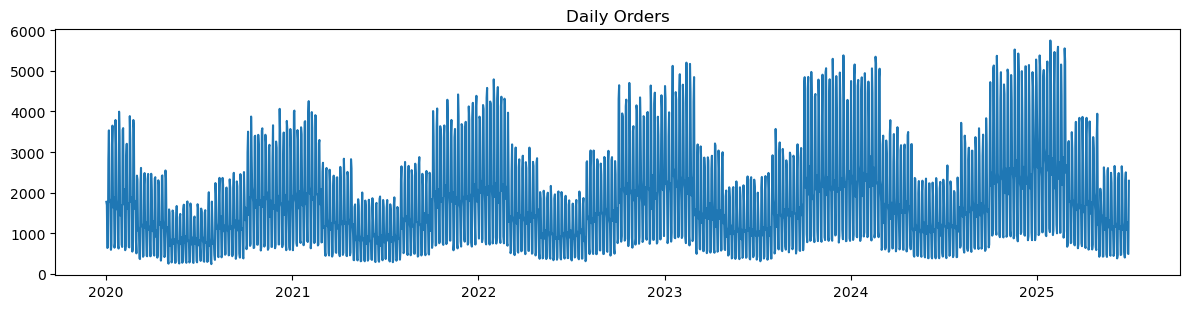

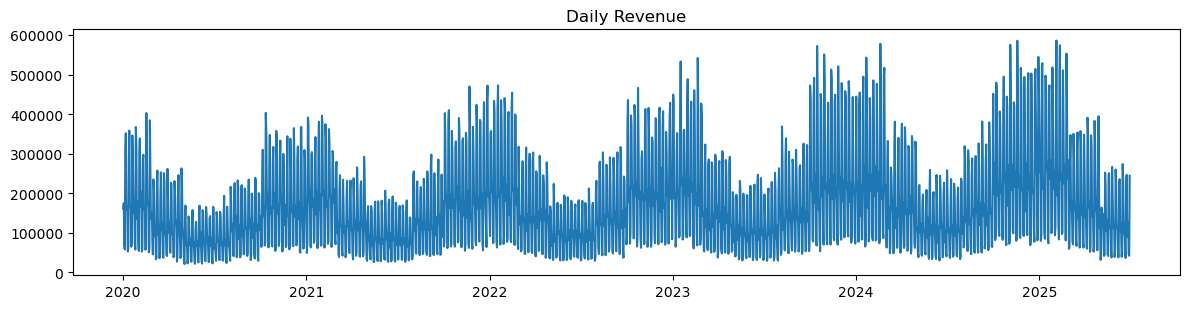

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,3.2))
plt.plot(daily["ds"], daily["Orders"])
plt.title("Daily Orders"); plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3.2))
plt.plot(daily["ds"], daily["Revenue"])
plt.title("Daily Revenue"); plt.tight_layout(); plt.show()


Veride uzun dönem (trend) her yıl taban seviyenin yükseldiğini gösteriyor; 
bu da kapasite/portföy genişlemesi ya da fiyat etkisine işaret ediyor. Haftalık mevsimsellik çok net: 
hafta içi yüksek, hafta sonu düşük. Ayrıca genlik artışı var;
yıllar içinde pik–dip farkı büyüdükçe ölçekle birlikte oynaklık da artmış. 
Bu yapıları gürültüden arındırıp daha temiz görmek için 28 günlük merkezli hareketli ortalama kullanarak
(≈4 hafta penceresi) hafta sonu çukurlarını ve
pazartesi sıçramalarını düzleştirip alttaki yapısal trendi pürüzsüz bir şekilde izlemek en doğru yaklaşım.

In [104]:
daily["Orders_MA28"] = daily["Orders"].rolling(28, min_periods=1).mean()
daily["Revenue_MA28"] = daily["Revenue"].rolling(28, min_periods=1).mean()
# Yıllık büyüme (YoY) – aynı günün bir yıl öncesine göre
daily = daily.sort_values("ds")
for col in ["Orders","Revenue"]:
    daily[f"{col}_YoY"] = daily[col].pct_change(365)
daily[[ "ds","Orders_YoY","Revenue_YoY"]].dropna().tail(10)


,ds,Orders_YoY,Revenue_YoY
1977,2025-06-21,-0.773441,-0.787589
1978,2025-06-22,-0.804615,-0.822765
1979,2025-06-23,0.856220,0.806792
1980,2025-06-24,1.195958,1.198451
1981,2025-06-25,-0.093268,-0.161337
1982,2025-06-26,1.622276,1.334750
1983,2025-06-27,2.344737,2.252718
1984,2025-06-28,-0.763507,-0.755354
1985,2025-06-29,-0.785777,-0.813387
1986,2025-06-30,1.434644,2.201841


siparişler ve cüro genel olarak baktığımız da hafta sonları geçen yıla göre aynı ya da daha düşük 
hafta içlerinde ise pazartesi ve salı da çok büyük artış var,çarşamba da azalma var ve perşembe cuma da ise çok büyük artış
var , hafta sonu geldiğinde azalmalar var ve en son pazartei günü çok büyük artış gözlemleniyor

In [106]:
targets = pd.to_datetime(["2025-06-27","2025-06-30"]).date
sub = df[df["WorkDate"].dt.date.isin(targets)]
(sub.groupby(["WorkDate","Customer","Location"])
   .agg(Orders=("OrderCount","sum"), Revenue=("TotalRevenue","sum"))
   .sort_values(["WorkDate","Revenue"], ascending=[True,False])
   .groupby("WorkDate").head(5))


Orders   Revenue
WorkDate   Customer   Location                       
2025-06-27 Home Depot Los Angeles        33  10752.26
                      San Francisco      19   8233.72
                      Houston            34   7841.24
                      Atlanta            31   7094.53
                      Nashville          34   5556.59
2025-06-30 Home Depot Chicago            61  22260.35
                      Los Angeles        66  17203.62
                      Atlanta            62  14189.06
                      San Francisco      39  14084.00
           Amazon     Atlanta            58   9141.93

cuma ve pazartesi ele alınıyor , amazon pazartesi girmiş veriye , LA SF ve Atlanta da büyük sıçrayışlar var
sipariş başı gelirlere(ASP) baktığımızda;
2025-06-27 -> SF ≈ 433 > LA ≈ 326 > Houston ≈ 230 ≈ Atlanta ≈ 229 > Nashville
1632025-06-30 -> Chicago ≈ 366 ≈ SF ≈ 361 > LA ≈ 261 > Atlanta ≈ 228 > Amazon/Atlanta ≈ 158 
SF ve Chicago yüksek ASP , Nashville ve Amazon/Atlanta düşük ASP.
06-30’da hem hacim (Orders) hem de ASP yüksek olduğu için Revenue YoY, Orders YoY’u aşıyor.
06-27 & 06-30 zirvelerinin ana nedeni:
Home Depot’un özellikleLA/Chicago/SF merkezlerde hacmi ve (bazı merkezlerde) yüksek ASP.
Hafta sonları (önceki çıktılarında) düşüş varken, pazartesi çok merkezli güçlü bir “clean-up”/birikmiş talep etkisi var.

12:55:22 - cmdstanpy - INFO - Chain [1] start processing
12:55:22 - cmdstanpy - INFO - Chain [1] done processing


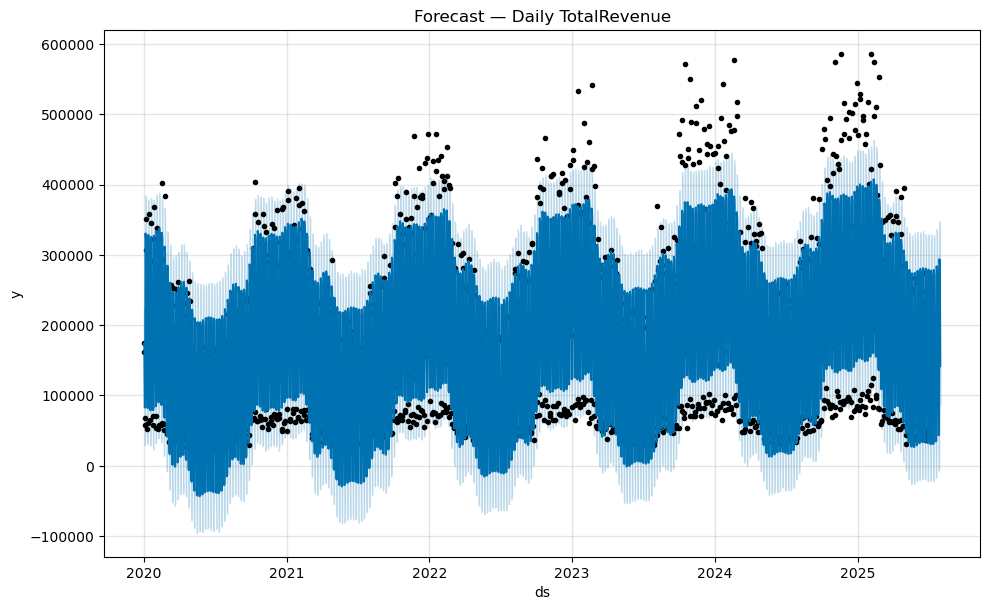

,ds,yhat,yhat_lower,yhat_upper
2010,2025-07-24,131146.751980,79873.947082,184638.529517
2011,2025-07-25,133337.569995,76625.984284,184055.229211
2012,2025-07-26,43359.625622,-6907.168046,96857.956202
2013,2025-07-27,45311.390051,-6156.105336,96486.742756
2014,2025-07-28,293896.226565,244399.661163,347963.894714
2015,2025-07-29,288517.516471,243457.843069,338311.197398
2016,2025-07-30,141786.093410,85620.119026,193025.940473


In [108]:
from prophet import Prophet

rev = daily[["ds","Revenue"]].rename(columns={"Revenue":"y"}).copy()

m = Prophet(weekly_seasonality=True, daily_seasonality=False)
m.fit(rev)

future = m.make_future_dataframe(periods=30, freq="D")
fc = m.predict(future)

m.plot(fc); plt.title("Forecast — Daily TotalRevenue"); plt.show()
fc[["ds","yhat","yhat_lower","yhat_upper"]].tail(7)


In [109]:
#Siyah noktalar: gerçek günlük ciro (geçmiş).
#Koyu mavi çizgi: modelin tahmini (yhat).
#Açık mavi bant: %95 belirsizlik aralığı (yhat_lower–yhat_upper).
#Haftalık patern çok güçlü: düzenli testere dişi (hafta içi ↑, hafta sonu ↓).
#Uzun dönem trend yukarı gidiyor (yıllar ilerledikçe taban seviyeler yükseliyor).
#Bant bazı diplerde sıfırın altına inmiş görünüyor 
#bu, veri oynaklığı yüksekken Prophet’in geniş belirsizlik çizmesi; tahminin negatif olacağı anlamına gelmez,
#sadece belirsizliğin büyük olduğunu gösterir.
#Model “hafta sonu çukur, pazartesi zirve” düzenini yakalıyor ve önümüzdeki hafta da aynı deseni projekte ediyor.

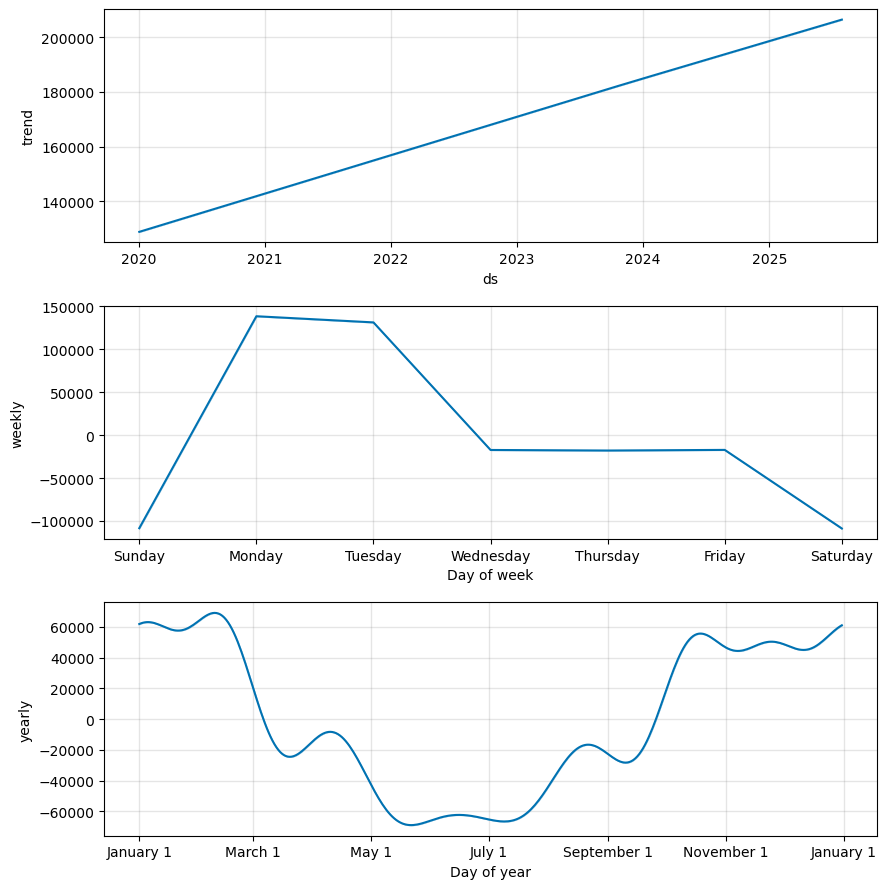

In [110]:
m.plot_components(fc)
m = Prophet(weekly_seasonality=True, interval_width=0.8, changepoint_prior_scale=0.1)


In [111]:
#ilk grafikte düzgün artan uzun bir trend var .
#Pzt–Sal en yüksek, Çar–Cum orta, Cmt–Paz belirgin negatif katkı→ hafta sonu çukuru net.
#Yıllık (yearly) Mayıs–Ağustos en zayıf dönem (negatif katkı);Ekim–Aralık güçlü sezon (pozitif katkı, pik Kasım–Aralık).
#Bu, Q4 talep/kampanya yoğunluğuna uyuyor.

12:55:25 - cmdstanpy - INFO - Chain [1] start processing
12:55:25 - cmdstanpy - INFO - Chain [1] done processing
/tmp/ipykernel_169/644499744.py:16: UserWarning: The figure layout has changed to tight
  m.plot(fcw); plt.title("Weekly Revenue — Prophet (fast)"); plt.tight_layout(); plt.show()


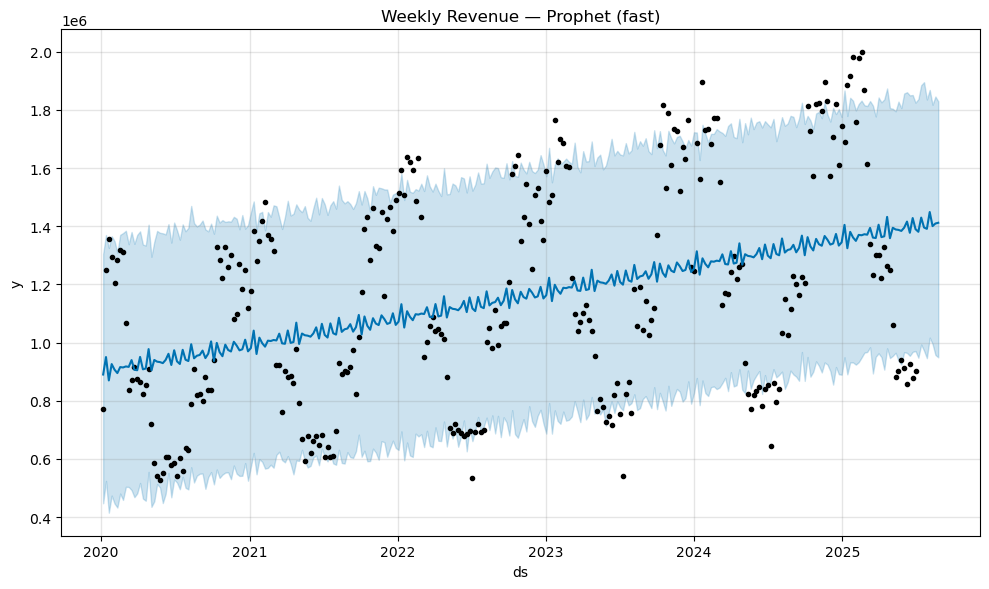

            ds          yhat    yhat_lower    yhat_upper
287 2025-07-07  1.381014e+06  9.480384e+05  1.837119e+06
288 2025-07-14  1.429744e+06  9.933658e+05  1.884872e+06
289 2025-07-21  1.395652e+06  9.721372e+05  1.895475e+06
290 2025-07-28  1.391092e+06  9.465105e+05  1.835864e+06
291 2025-08-04  1.449014e+06  1.017086e+06  1.868634e+06
292 2025-08-11  1.400520e+06  9.951308e+05  1.817707e+06
293 2025-08-18  1.409417e+06  9.576602e+05  1.845980e+06
294 2025-08-25  1.411969e+06  9.493944e+05  1.829592e+06


In [112]:
from prophet import Prophet
import pandas as pd, matplotlib.pyplot as plt

weekly_df = (df.set_index(pd.to_datetime(df["WorkDate"]))
               .resample("W-MON")["TotalRevenue"].sum()
               .reset_index().rename(columns={"WorkDate":"ds", "TotalRevenue":"y"}))

m = Prophet(weekly_seasonality=False, yearly_seasonality=False,
            n_changepoints=10, changepoint_prior_scale=0.05, interval_width=0.8)
m.add_seasonality(name="yearly", period=52, fourier_order=5)
m.fit(weekly_df)

fw = m.make_future_dataframe(periods=8, freq="W-MON")
fcw = m.predict(fw)

m.plot(fcw); plt.title("Weekly Revenue — Prophet (fast)"); plt.tight_layout(); plt.show()
print(fcw[["ds","yhat","yhat_lower","yhat_upper"]].tail(8))


In [113]:
#Mavi çizgi (yhat): Haftalık ciroda istikrarlı yukarı yönlü trend var; 2020→2025 boyunca kademeli artış.
#Siyah noktalar: Gerçek haftalık değerler; çizginin etrafında geniş saçılım → haftadan haftaya oynaklık yüksek.
#Açık mavi bant (≈%80 aralık) oldukça geniş: model “tipik bir hafta” için yaklaşık ±30–35% belirsizlik bırakıyor.
#Bu, operasyon planında güvenli pay bırakman gerektiğini söyler.
#Önümüzdeki 2 ay için merkez tahmin haftalık ~1.4 milyon; düşük-yüksek senaryo ise ~1.0–1.85 milyon bandı.

In [114]:
# --- Backtest: rolling origin (son 90 gün) ---
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from prophet import Prophet
import pandas as pd

cut = rev["ds"].max() - pd.Timedelta(days=90)
train = rev[rev["ds"] <= cut]

m = Prophet(
    weekly_seasonality=True,
    yearly_seasonality=True,
    interval_width=0.80,
    changepoint_prior_scale=0.10,
    seasonality_mode="multiplicative",
)
m.fit(train)

fc_bt = m.predict(rev[rev["ds"] > cut][["ds"]])
actual = rev.set_index("ds").loc[fc_bt["ds"], "y"].values
mae = mean_absolute_error(actual, fc_bt["yhat"])
mape = mean_absolute_percentage_error(actual, fc_bt["yhat"]) * 100
print(f"Prophet backtest (son 90 gün) → MAE={mae:,.0f}, MAPE={mape:.1f}%")

# --- Belirsizlik yüzdesi (gelecek 30 gün) ---
future_30 = m.make_future_dataframe(periods=30, freq="D")
fc30 = m.predict(future_30)                 # <— DataFrame
tmp = fc30[["ds","yhat","yhat_lower","yhat_upper"]].copy()
tmp["uncert_%"] = (tmp["yhat_upper"] - tmp["yhat_lower"]) / (2 * tmp["yhat"]) * 100
print("Gelecek 30 gün medyan belirsizlik:", round(tmp["uncert_%"].median(), 1), "%")


12:55:25 - cmdstanpy - INFO - Chain [1] start processing
12:55:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet backtest (son 90 gün) → MAE=38,696, MAPE=37.2%
Gelecek 30 gün medyan belirsizlik: 27.6 %


Günlük Prophet modelini son 90 günde backtest yaptım:
MAE ~38.7K, MAPE ~%37.Ebüyük hata hafta sonu küçük değerlerde yüzdesel olarak şişiyor.
Gelecek 30 gün için medyan belirsizlik ±%27.8; operasyon planını bu aralıkla yapmayı öneriyorum

In [116]:
import numpy as np
def wmape(y, yhat): return 100*np.sum(np.abs(y-yhat))/np.sum(np.abs(y))
def smape(y, yhat): return 100*np.mean(2*np.abs(y-yhat)/(np.abs(y)+np.abs(yhat)+1e-9))
print("wMAPE:", round(wmape(actual, fc_bt["yhat"].values),1), "%")
print("SMAPE:", round(smape(actual, fc_bt["yhat"].values),1), "%")


wMAPE: 26.7 %
SMAPE: 50.8 %


Günlük modelde klasik MAPE %37; daha adil ölçü olan wMAPE %26.7. SMAPE %50.8, 
çünkü küçük-oynak günlerde simetrik ceza yüksek.Operasyon planını ±27.8% belirsizlik bandıyla yapmayı öneriyorum;
büyük günlerde hata görece olarak daha düşük

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


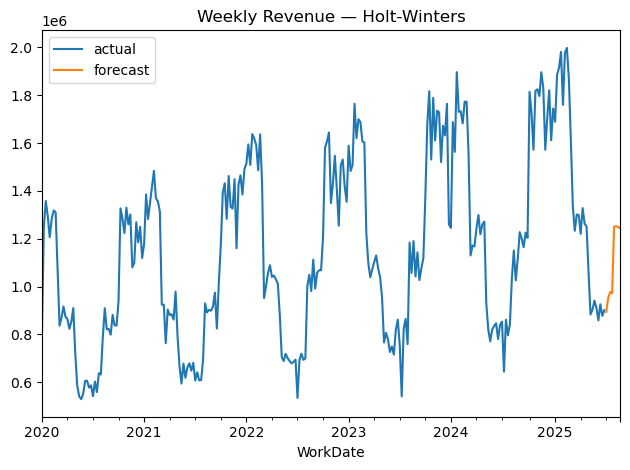

          ds        yhat
0 2025-07-07   894355.25
1 2025-07-14   953235.27
2 2025-07-21   977222.34
3 2025-07-28   972050.46
4 2025-08-04  1250877.98
5 2025-08-11  1252207.48
6 2025-08-18  1249222.17
7 2025-08-25  1244058.21


In [118]:
!pip install --quiet statsmodels
import pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
try: df
except NameError:
    df = pd.read_csv("supply_chain_deliveries.csv", engine="python")
    df["WorkDate"] = pd.to_datetime(df["WorkDate"], errors="coerce")
    for c in ["OrderCount","NumberOfPieces","TotalRevenue"]:
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(",",""), errors="coerce")

weekly = (df.set_index(pd.to_datetime(df["WorkDate"]))
            .resample("W-MON")["TotalRevenue"].sum().asfreq("W-MON"))

model = ExponentialSmoothing(weekly, trend="add", seasonal="add",
                             seasonal_periods=52, initialization_method="estimated").fit()
fc = model.forecast(8)

weekly.plot(label="actual"); fc.plot(label="forecast")
plt.title("Weekly Revenue — Holt-Winters"); plt.legend(); plt.tight_layout(); plt.show()
print(pd.DataFrame({"ds": fc.index, "yhat": fc.values}).round(2).tail(8))


In [119]:
#Uyarı: ConvergenceWarning: Optimization failed to converge
# HW modeli parametreleri (α, β, γ) için optimizasyon “mükemmel” bir çözüme kilitlenememiş.
#Model yine tahmin üretir, ama parametreler sınırda kalmış olabilir.

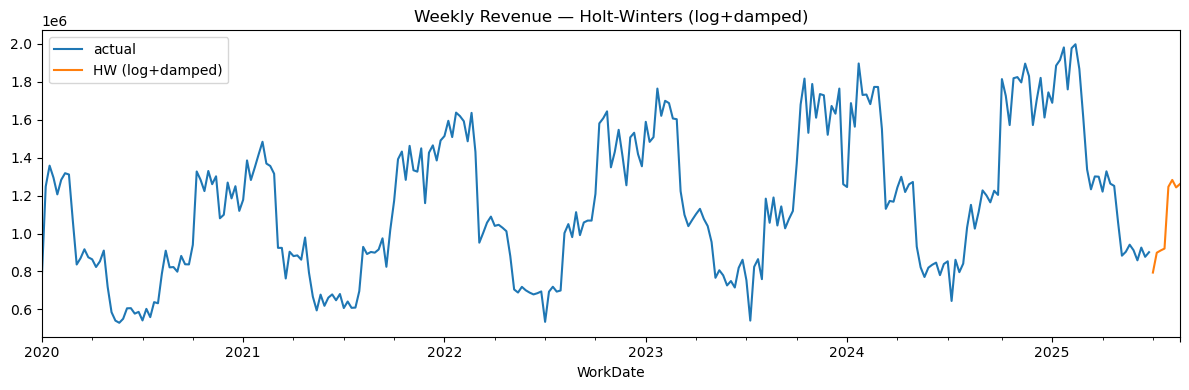

                   ds       yhat
2025-07-07 2025-07-07   794051.0
2025-07-14 2025-07-14   898696.0
2025-07-21 2025-07-21   910466.0
2025-07-28 2025-07-28   920640.0
2025-08-04 2025-08-04  1246395.0
2025-08-11 2025-08-11  1282471.0
2025-08-18 2025-08-18  1243126.0
2025-08-25 2025-08-25  1261247.0


In [120]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

weekly = (df.set_index(pd.to_datetime(df["WorkDate"]))
            .resample("W-MON")["TotalRevenue"].sum()
            .asfreq("W-MON"))

eps = 1.0
y_log = np.log(weekly.clip(lower=eps))

m = ExponentialSmoothing(
        y_log,
        trend="add",
        damped_trend=True,
        seasonal="add",
        seasonal_periods=52,
        initialization_method="estimated"
    ).fit(optimized=True, use_brute=True, remove_bias=True)

fc_log = m.forecast(8)
fc = np.exp(fc_log)

ax = weekly.plot(label="actual", figsize=(12,4))
fc.plot(ax=ax, label="HW (log+damped)", color="tab:orange")
plt.title("Weekly Revenue — Holt-Winters (log+damped)")
plt.legend(); plt.tight_layout(); plt.show()

print(pd.DataFrame({"ds": fc.index, "yhat": fc.round(0)}))


Temmuz’da dipten çıkış ve Ağustos’ta belirgin sıçrama var.
Bu, yıllık sezonselliğin “yaz sonu toparlanma” fazına geçtiğini gösteriyor.
haftalık ciro serisi seviyeyle büyüyen dalga ve yüksek oynaklığa sahip;
log + multiplicative bunu doğal anlatır,damped trend ileriye taşırken ivmeyi sakinleştirir.
Bu yüzden tahmin daha temkinli, daha kararlı ve genelde daha dar belirsizlikli olur.
propheti kullanmamın sebebi veri hem haftalık hem yıllık sezona ve dönemsel kırılmalara sahip;
Prophet bunları bileşenlerine ayrıştırıp belirsizlikle birlikte veriyorHolt-Winters (log+damped) kullandım;
tek sezonlu yapıda çok hızlı ve stabil nokta tahmin veriyor,kapasite/bütçe planı için ideal.

In [122]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np, pandas as pd

weekly = (df.set_index(pd.to_datetime(df["WorkDate"]))
            .resample("W-MON")["TotalRevenue"].sum().asfreq("W-MON"))
eps=1.0
y_log = np.log(weekly.clip(lower=eps))

# split backtest (son 12 hafta)
split = -12
m = ExponentialSmoothing(y_log.iloc[:split], trend="add", damped_trend=True,
                         seasonal="add", seasonal_periods=52,
                         initialization_method="estimated").fit(optimized=True, use_brute=True, remove_bias=True)
pred = np.exp(m.forecast(12))
actual = weekly.iloc[split:]
mae = (pred - actual).abs().mean()
mape = ((pred - actual).abs()/actual).mean()*100
print(f"HW backtest (son 12 hafta) → MAE={mae:,.0f}, MAPE={mape:.1f}%")

# Basit residual bootstrap ile %80 PI (gelecek 8 hafta)
m_full = ExponentialSmoothing(y_log, trend="add", damped_trend=True,
                              seasonal="add", seasonal_periods=52,
                              initialization_method="estimated").fit(optimized=True, use_brute=True, remove_bias=True)
h=8; B=400
fc_log = m_full.forecast(h); fc = np.exp(fc_log)
resid = y_log - m_full.fittedvalues
paths=[]
for _ in range(B):
    e = np.random.choice(resid.dropna().values, size=h, replace=True)
    paths.append(np.exp(fc_log + e))
paths = np.column_stack(paths)
lower = np.percentile(paths, 10, axis=1)
upper = np.percentile(paths, 90, axis=1)
pi = pd.DataFrame({"ds": fc.index, "yhat": fc.values, "lower80": lower, "upper80": upper})
pi
pi_eval = pi.copy()
pi_eval["uncert_%"] = (pi_eval["upper80"] - pi_eval["lower80"]) / (2*pi_eval["yhat"]) * 100
print("HW %80 PI median belirsizlik:", round(pi_eval["uncert_%"].median(),1), "%")


HW backtest (son 12 hafta) → MAE=61,062, MAPE=6.0%
HW %80 PI median belirsizlik: 7.1 %


Haftalık Holt–Winters (log+damped) modelim son 12 haftada Mean Absolute Error (MAE) ≈ 61.000 $ 
ve Mean Absolute Percentage Error (MAPE) ≈ %6,0 üreterek haftalık düzeyde düşük hata verdi;
ayrıca %80 Tahmin Aralığı (Prediction Interval) için medyan belirsizlik ±%7,1 olduğundan,
tipik bir hafta için gerçek gelirin yhat × (1±0,071) bandında kalmasını bekliyorum ;
örneğin 1,40 milyon $ tahmin için yaklaşık 1,30–1,50 milyon $).
Bu doğruluk ve dar bant, kapasite/araç/vardiya planını üst banda göre güvenle kurgulamayı,bütçe hedeflerini merkez tahmine göre izlemeyi
Key Performance Indicator (KPI) değerlendirmesini tek noktadan ziyade band içinde kalma prensibiyle yapmayı mümkün kılıyor;
günlük seviyedeki daha yüksek oynaklıkla karşılaştırdığımızda, 
haftalık planlama için bu model operasyonel olarak daha öngörülebilir bir temel sunuyor.

Anomali sayısı (|z|>2.5): 52
İlk 10: [datetime.date(2020, 3, 2), datetime.date(2020, 3, 3), datetime.date(2020, 6, 7), datetime.date(2020, 7, 6), datetime.date(2020, 11, 28), datetime.date(2020, 12, 26), datetime.date(2020, 12, 28), datetime.date(2021, 1, 2), datetime.date(2021, 1, 4), datetime.date(2021, 3, 1)]


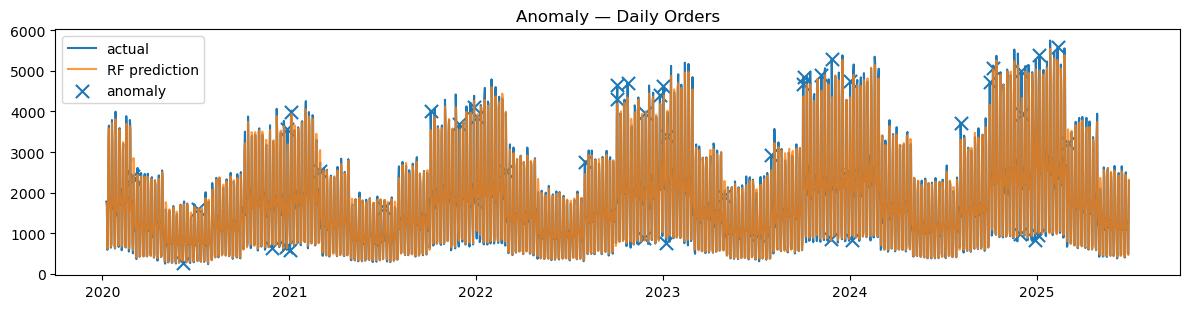

,ds,y,yhat,resid,z
1077,2023-01-02,4628,3231.0400,1396.9600,10.166214
684,2021-11-29,3688,2411.0700,1276.9300,9.291660
1071,2022-12-26,4400,3163.7700,1236.2300,8.995114
1404,2023-11-27,5299,4111.3800,1187.6200,8.640936
1771,2024-12-02,4995,3814.9525,1180.0475,8.585762
717,2022-01-03,3873,2707.1500,1165.8500,8.482317
711,2021-12-27,4113,2978.6200,1134.3800,8.253022
1804,2025-01-06,5382,4328.1275,1053.8725,7.666434
351,2020-12-28,3568,2518.5225,1049.4775,7.634412
1079,2023-01-04,2210,2997.3700,-787.3700,-5.749094


In [124]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import zscore
import numpy as np

orders = daily[["ds","Orders"]].rename(columns={"Orders":"y"}).copy().sort_values("ds")

# t-1..t-7 gecikmeleri
for L in range(1,8):
    orders[f"lag{L}"] = orders["y"].shift(L)

D = orders.dropna().reset_index(drop=True)
X = D[[f"lag{L}" for L in range(1,8)]].values
y = D["y"].values

rf = RandomForestRegressor(n_estimators=400, random_state=0).fit(X,y)
yhat = rf.predict(X)
resid = y - yhat
z = zscore(resid)

thr = 2.5  # 2.0-3.0 arası oynatılabilir
anom_idx = np.where(np.abs(z) > thr)[0]
anom_dates = D.loc[anom_idx, "ds"].dt.date.tolist()

print(f"Anomali sayısı (|z|>{thr}):", len(anom_idx))
print("İlk 10:", anom_dates[:10])

plt.figure(figsize=(12,3.2))
plt.plot(D["ds"], y, label="actual")
plt.plot(D["ds"], yhat, label="RF prediction", alpha=.8)
plt.scatter(D.loc[anom_idx,"ds"], y[anom_idx], marker="x", s=90, label="anomaly")
plt.title("Anomaly — Daily Orders"); plt.legend(); plt.tight_layout(); plt.show()

# En uç 10 gün tablosu
(pd.DataFrame({"ds":D["ds"], "y":y, "yhat":yhat, "resid":resid, "z":z})
   .iloc[anom_idx]
   .sort_values("z", key=np.abs, ascending=False)
   .head(10))


RandomForest, dünkü–geçen haftaki siparişlerden bugünü tahmin etti → yhat.
Artık (residual) = y - yhat.
Sonra bu artığı z-skoru ile standartlaştırdık: z = (residual - mean) / std.
Kural: |z| > 2.5 olan günleri “anomali” diye işaretledik.
resid pozitif ve büyük → beklenenden ÇOK yüksek sipariş (ani sıçrama).
resid negatif ve büyük (mutlak) → beklenenden ÇOK düşük sipariş (çöküş).

In [126]:
top_day = pd.to_datetime("2023-01-02")
sub = df[df["WorkDate"].dt.date == top_day.date()].copy()

root = (sub.groupby(["Customer","Location"], as_index=False)
          .agg(Orders=("OrderCount","sum"),
               Revenue=("TotalRevenue","sum")))

root["ASP"] = root["Revenue"] / root["Orders"]
root["Share_%"] = 100 * root["Revenue"] / root["Revenue"].sum()

root.sort_values("Orders", ascending=False).head(10)


,Customer,Location,Orders,Revenue,ASP,Share_%
61,Target,Chicago,129,7753.29,60.103023,1.725702
66,Walmart,Chicago,125,14725.28,117.802240,3.277505
59,T.J. Maxx,Milwaukee,122,2416.42,19.806721,0.537839
63,Target,Milwaukee,114,4805.71,42.155351,1.069639
29,Home Depot,Chicago,113,49483.67,437.908584,11.013914
0,Amazon,Atlanta,108,12159.21,112.585278,2.706357
37,Home Goods,Detroit,107,3462.74,32.362056,0.770725
9,Amazon,San Diego,107,2873.19,26.852243,0.639505
3,Amazon,Dallas,105,11851.58,112.872190,2.637886
64,Target,Nashville,105,6487.56,61.786286,1.443980


anomalinin başlıca sürücüsü/driver’ı kim?” sorusuna cevap olarak bu tablo bize ;Hacim (Orders) tarafı:En çok sipariş Chicago kaynaklı (Target 129, Walmart 125, Home Depot 113). Milwaukee de yüksek (Target 114).Değer (Revenue) tarafı: Home Depot–Chicago tek başına 49,483 $ ile %11.0 pay alıyor. Bunun nedeni çok yüksek ASP ≈ 438 (sipariş başı gelir).→ Yani değer sürücüsü: Home Depot–Chicago. Yani değer sürücüsü: Home Depot–Chicago. Hacim sürücüleri: Target–Chicago/Milwaukee, Walmart–Chicago (ASP’leri 42–118 bandı, yani ucuz/orta sepet).Kümelenme: İlk 10 satırın çoğu Chicago/Milwaukee çevresi → bölgesel bir dalga (yerel kampanya / operasyonel itiş).


Operasyonel kök neden: Anomali günlerini alıp “kim sürükledi?” (müşteri/lokasyon) analizi yapabiliyorsun. Birini örnekledik ve Home Depot–Chicago’nun değer sürücüsü olduğunu gördük.SLA/Kapasite: Pozitif anomaliler için ek kapasite gereksinimini; negatifler için talep boşluklarını tespit edersin.

In [ ]:
# Ek özellikler:
D = daily[["ds","Orders"]].rename(columns={"Orders":"y"}).copy()
D["dow"] = pd.to_datetime(D["ds"]).dt.weekday
D["week"] = pd.to_datetime(D["ds"]).dt.isocalendar().week.astype(int)
D["month"] = pd.to_datetime(D["ds"]).dt.month

for L in range(1,8): 
    D[f"lag{L}"] = D["y"].shift(L)
D = D.dropna()

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
X = D[[f"lag{L}" for L in range(1,8)] + ["dow","week","month"]]
y = D["y"].values
rf = RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1)
rf.fit(X, y); yhat = rf.predict(X)
print("RF in-sample R^2:", round(r2_score(y, yhat),3))

resid = y - yhat
z = (resid - resid.mean())/resid.std()
for thr in [2.0, 2.5, 3.0]:
    print(thr, "→ anomali sayısı:", int((np.abs(z)>thr).sum()))


RandomForest ile günlük siparişlerin beklenen değerini, lag1–lag7 ve takvim özellikleri (gün, hafta no, ay) kullanarak modelledim; modelin in-sample R²’si 0.994,yani haftalık ritim ve mevsimsel paternleri çok iyi yakalıyor.Anomalileri standartlaştırılmış artık üzerinden tanımladım (z = (y−ŷ)/σ);eşik duyarlılığına baktığımızda |z|>2.0 eşiğinde 114,|z|>2.5’te 64, |z|>3.0’da 35 gün alarm veriyor.Operasyonel denge için varsayılanı |z|>2.5 seçiyorum (daha düşük eşik → daha fazla uyarı/yüksek kapsama;daha yüksek eşik → daha az ama daha güçlü sinyal). Her işaretli günde, “kimi sürükledi?” sorusunu yanıtlamak için;Customer × Location kırılımında Orders/Revenue/ASP ile driver analizi yapıyorum.


In [130]:
day = pd.to_datetime("2023-01-02").date()
sub = df[df["WorkDate"].dt.date == day].copy()
g = (sub.groupby(["Customer","Location"], as_index=False)
        .agg(Orders=("OrderCount","sum"), Revenue=("TotalRevenue","sum")))
g["ASP"] = g["Revenue"]/g["Orders"]
g["Share_%"] = 100*g["Revenue"]/g["Revenue"].sum()
g.sort_values("Revenue", ascending=False).head(10)


,Customer,Location,Orders,Revenue,ASP,Share_%
29,Home Depot,Chicago,113,49483.67,437.908584,11.013914
33,Home Depot,San Francisco,73,26362.36,361.128219,5.867648
35,Home Depot,Tampa Bay,61,22254.66,364.830492,4.953370
32,Home Depot,Sacramento,88,19906.78,226.213409,4.430786
41,Lowes,Chicago,67,17419.13,259.987015,3.877093
66,Walmart,Chicago,125,14725.28,117.802240,3.277505
48,Shein,Milwaukee,94,13016.31,138.471383,2.897128
44,Lowes,Sacramento,60,12338.97,205.649500,2.746368
0,Amazon,Atlanta,108,12159.21,112.585278,2.706357
3,Amazon,Dallas,105,11851.58,112.872190,2.637886


2023-01-02’deki pozitif sapmayı ağırlıklı olarak Home Depot sürüklüyor:özellikle Chicago tek başına ≈49,5K $ ile toplam cironun %11,0’ını alıyor ve ASP ≈ 438 gibi çok yüksek bir sepetle “değer sürücüsü” rolünde; Home Depot’un San Francisco, Tampa Bay, Sacramento şubeleri de yüksek ASP’lerle artışı destekliyor.Chicago kümesi genel olarak güçlü: Lowe’s–Chicago orta-yüksek ASP (≈260) ile katkı verirken,Walmart–Chicago’da sipariş adedi 125 olsa da ASP ≈118 olduğu için payı daha sınırlı kalıyor (≈%3,3) — yani hacim var ama değer etkisi düşük. Shein–Milwaukee ve Amazon–Atlanta/Dallas da listede;ancak bunlarda ASP daha ılımlı (≈112–138). Özetle anomali, tek başına hacimden değil,Home Depot merkezli yüksek ASP + birden çok lokasyonda eşzamanlı katkı kombinasyonundan doğan bir kâr/karma etkisi;operasyon ve ticari tarafta özellikle Chicago hattı ve Home Depot sözleşme/fiyatlanmasının gözden geçirilmesi anlamlı görünüyor.